In [2]:
import cv2
from ultralytics import  YOLO
import numpy as np
import matplotlib as mpl

# Load a pretrained YOLOv8n model
model = YOLO("C:/Users/F/OneDrive/Desktop/aligner/best.pt")

# Run inference on the image
results = model("C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_0_8192.png", save=True, show_labels=False, save_txt=True, save_conf=True, conf=0.0001)

# Load the image
image_path = "C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_0_8192.png"
image = cv2.imread(image_path)

# Iterate over the results and draw bounding boxes or lines
for result in results:
    boxes = result.boxes  # Extract the boxes from the result
    for box in boxes:
        # Extract bounding box coordinates and class
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # Convert to integer list
        conf = box.conf[0].item()  # Extract confidence score
        cls = int(box.cls[0].item())  # Extract class index

        # Normalize confidence to a value between 0 and 1 for color mapping
        conf_line = np.clip(conf, 0, 1)  # Ensure it stays within [0, 1]
        
        # Get color based on confidence (winter colormap)
        color = mpl.cm.winter(conf_line)  
        color = (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))  # Convert to BGR format

        # Draw positive or negative diagonal based on the class
        if cls == 1:  # Class 0: Draw positive diagonal
            cv2.line(image, (x1, y1), (x2, y2), color, 2)  # Line with mapped color
        elif cls == 0:  # Class 1: Draw negative diagonal
            cv2.line(image, (x1, y2), (x2, y1), color, 2)  # Line with mapped color
       
# Save the resulting image
output_path = "C:/Users/F/OneDrive/Desktop/aligner/result_image.png"
cv2.imwrite(output_path, image)



image 1/1 C:\Users\F\OneDrive\Desktop\dataloader\Physical_Cells2\train\images\physical_cell_0_8192.png: 1024x1024 116 class_0s, 184 class_1s, 833.9ms
Speed: 21.9ms preprocess, 833.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\detect\predict7
1 label saved to runs\detect\predict7\labels


True

wighted kmeans 

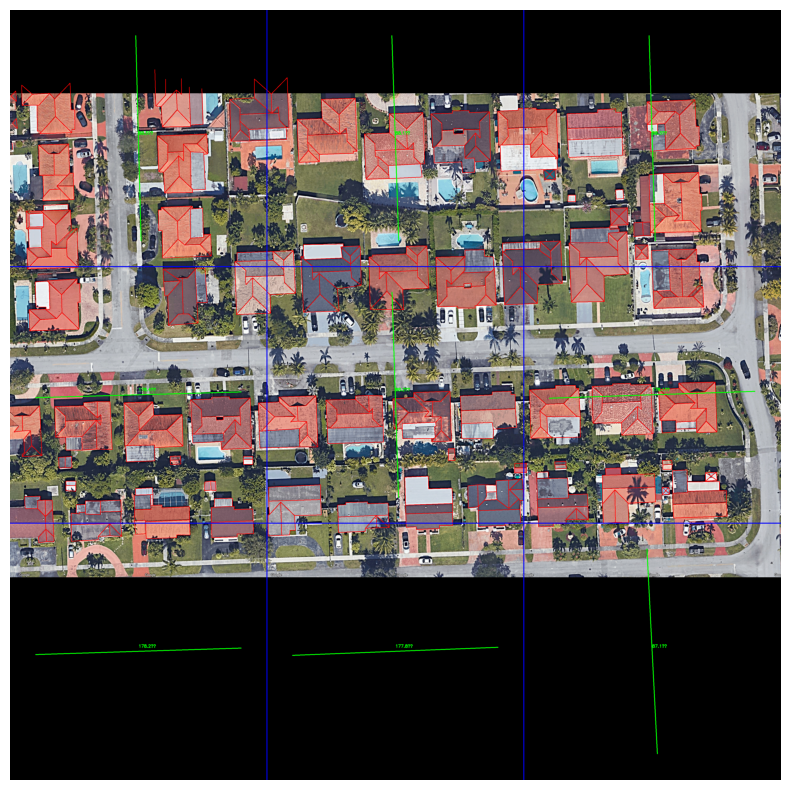

In [1]:
import os
import pickle
import numpy as np
import cv2
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

# Increase maximum image size
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        image = np.array(img)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def load_pickle(pickle_path: str):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    return data

def calculate_line_properties(points):
    x1, y1 = points[0]
    x2, y2 = points[-1]
    dx = x2 - x1
    dy = y2 - y1
    angle = math.degrees(math.atan2(dy, dx))
    if angle < 0:
        angle += 180
    length = math.sqrt(dx**2 + dy**2)
    return angle, length

def weighted_kmeans(angles, weights, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(np.array(angles).reshape(-1, 1), sample_weight=weights)
    return kmeans.labels_, kmeans.cluster_centers_

def display_lines_and_clusters(image: np.ndarray, data: list, grid_size=(3, 3), thickness=2):
    # Initialize a list to hold line information
    lines = []
    
    # Extract lines from the data
    for entry in data:
        if isinstance(entry, dict) and 'points' in entry:  # Ensure 'points' key exists
            points = entry['points']  # Get points for the line
            lines.append({'points': points})  # Append to lines as a dictionary
    
    height, width = image.shape[:2]
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]

    # Initialize grid cells
    grid_cells = [[[] for _ in range(grid_size[1])] for _ in range(grid_size[0])]

    # Assign lines to grid cells
    for line in lines:
        points = line['points']
        angle, length = calculate_line_properties(points)
        
        # Determine which grid cell(s) the line belongs to
        start_row, start_col = int(points[0][1]) // cell_height, int(points[0][0]) // cell_width
        end_row, end_col = int(points[-1][1]) // cell_height, int(points[-1][0]) // cell_width
        
        # Add line to all relevant grid cells, including overlapping areas
        min_row, max_row = min(start_row, end_row), max(start_row, end_row)
        min_col, max_col = min(start_col, end_col), max(start_col, end_col)
        
        for row in range(min_row, min(grid_size[0], max_row + 1)):
            for col in range(min_col, min(grid_size[1], max_col + 1)):
                grid_cells[row][col].append((angle, length, points))

        # Draw the original line
        cv2.polylines(image, [np.array(points, dtype=np.int32)], False, (0, 0, 255), thickness)

    # Process each grid cell
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            cell_lines = grid_cells[row][col]
            if cell_lines:
                angles, lengths = zip(*[(line[0], line[1]) for line in cell_lines])
                
                # Determine number of clusters as min(6, number of lines in the grid cell)
                n_clusters = min(8, len(angles))
                
                # Apply weighted k-means clustering
                labels, centers = weighted_kmeans(angles, lengths, n_clusters)
                
                # Find the cluster with the highest total weight (length)
                cluster_weights = [sum(lengths[i] for i in range(len(labels)) if labels[i] == j) for j in range(len(centers))]
                dominant_cluster = np.argmax(cluster_weights)
                dominant_angle = centers[dominant_cluster][0]
                
                # Draw the dominant orientation line for this cell
                cell_center_x = (col + 0.5) * cell_width
                cell_center_y = (row + 0.5) * cell_height
                line_length = min(cell_width, cell_height) * 0.8
                angle_rad = math.radians(dominant_angle)
                dx = math.cos(angle_rad) * line_length / 2
                dy = math.sin(angle_rad) * line_length / 2
                start_x = int(cell_center_x - dx)
                start_y = int(cell_center_y - dy)
                end_x = int(cell_center_x + dx)
                end_y = int(cell_center_y + dy)
                
                # Draw the dominant orientation line
                cv2.line(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 3)
                
                # Add text to show the dominant angle
                text_position = (int(cell_center_x), int(cell_center_y) - 20)
                cv2.putText(image, f"{dominant_angle:.1f}°", text_position, 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)

    # Draw grid lines
    for i in range(1, grid_size[0]):
        cv2.line(image, (0, i * cell_height), (width, i * cell_height), (255, 0, 0), 3)
    for j in range(1, grid_size[1]):
        cv2.line(image, (j * cell_width, 0), (j * cell_width, height), (255, 0, 0), 3)

    return image

def main():
    # Define image and pickle file paths
    image_path = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_1024_43008.png'
    pickle_path = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_1024_43008.pkl'
    
    # Load image and pickle file
    image = load_image(image_path)
    data = load_pickle(pickle_path)
    
    # Display lines and perform clustering
    image_with_lines_and_clusters = display_lines_and_clusters(image.copy(), data, grid_size=(3, 3), thickness=2)
    
    # Display the final image
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(image_with_lines_and_clusters, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()



neighbor clustring

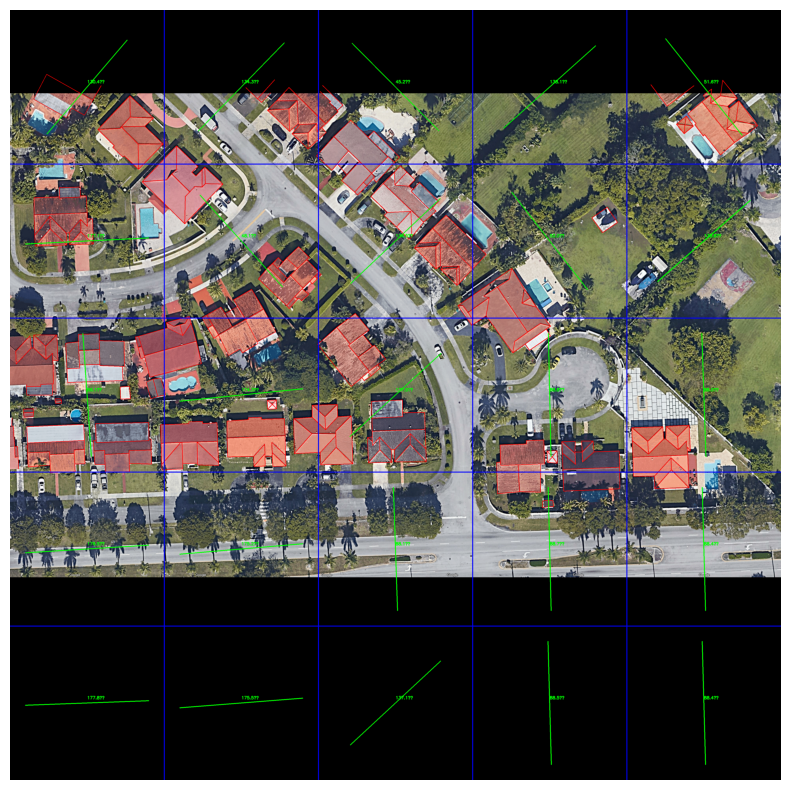

In [2]:
import os
import pickle
import numpy as np
import cv2
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

# Increase maximum image size
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        image = np.array(img)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def load_pickle(pickle_path: str):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    return data

def calculate_line_properties(points):
    x1, y1 = points[0]
    x2, y2 = points[-1]
    dx = x2 - x1
    dy = y2 - y1
    angle = math.degrees(math.atan2(dy, dx))
    if angle < 0:
        angle += 180
    length = math.sqrt(dx**2 + dy**2)
    return angle, length

def weighted_kmeans(angles, weights, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(np.array(angles).reshape(-1, 1), sample_weight=weights)
    return kmeans.labels_, kmeans.cluster_centers_

def calculate_grid_distance(i1, j1, i2, j2):
    return abs(i2 - i1) + abs(j2 - j1)

def display_lines_and_clusters(image: np.ndarray, data: list, grid_size=(5, 5), thickness=2):
    height, width = image.shape[:2]
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]

    # Initialize grid cells
    grid_cells = [[[] for _ in range(grid_size[1])] for _ in range(grid_size[0])]

    # Assign lines to grid cells
    for entry in data:
        if isinstance(entry, dict) and 'points' in entry:
            points = entry['points']
            angle, length = calculate_line_properties(points)
            
            # Determine which grid cell(s) the line belongs to
            start_row, start_col = int(points[0][1]) // cell_height, int(points[0][0]) // cell_width
            end_row, end_col = int(points[-1][1]) // cell_height, int(points[-1][0]) // cell_width
            
            # Add line to all relevant grid cells, including overlapping areas
            min_row, max_row = min(start_row, end_row), max(start_row, end_row)
            min_col, max_col = min(start_col, end_col), max(start_col, end_col)
            
            for row in range(min_row, min(grid_size[0], max_row + 1)):
                for col in range(min_col, min(grid_size[1], max_col + 1)):
                    grid_cells[row][col].append((angle, length, points))

            # Draw the original line
            cv2.polylines(image, [np.array(points, dtype=np.int32)], False, (0, 0, 255), thickness)

    # Process each grid cell
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            all_angles = []
            all_weights = []
            
            # Consider lines from all grid cells
            for i2 in range(grid_size[0]):
                for j2 in range(grid_size[1]):
                    cell_lines = grid_cells[i2][j2]
                    for angle, length, _ in cell_lines:
                        d = calculate_grid_distance(i, j, i2, j2)
                        weight = length / (((d * 3) + 1) ** 2)
                        all_angles.append(angle)
                        all_weights.append(weight)
            
            if all_angles:
                # Determine number of clusters
                n_clusters = min(6, len(all_angles))
                
                # Apply weighted k-means clustering
                labels, centers = weighted_kmeans(all_angles, all_weights, n_clusters)
                
                # Find the cluster with the highest total weight
                cluster_weights = [sum(all_weights[k] for k in range(len(labels)) if labels[k] == c) for c in range(len(centers))]
                dominant_cluster = np.argmax(cluster_weights)
                dominant_angle = centers[dominant_cluster][0]
                
                # Draw the dominant orientation line for this cell
                cell_center_x = (j + 0.5) * cell_width
                cell_center_y = (i + 0.5) * cell_height
                line_length = min(cell_width, cell_height) * 0.8
                angle_rad = math.radians(dominant_angle)
                dx = math.cos(angle_rad) * line_length / 2
                dy = math.sin(angle_rad) * line_length / 2
                start_x = int(cell_center_x - dx)
                start_y = int(cell_center_y - dy)
                end_x = int(cell_center_x + dx)
                end_y = int(cell_center_y + dy)
                
                # Draw the dominant orientation line
                cv2.line(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 3)
                
                # Add text to show the dominant angle
                text_position = (int(cell_center_x), int(cell_center_y) - 20)
                cv2.putText(image, f"{dominant_angle:.1f}°", text_position, 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)

    # Draw grid lines
    for i in range(1, grid_size[0]):
        cv2.line(image, (0, i * cell_height), (width, i * cell_height), (255, 0, 0), 3)
    for j in range(1, grid_size[1]):
        cv2.line(image, (j * cell_width, 0), (j * cell_width, height), (255, 0, 0), 3)

    return image

def main():
    # Define image and pickle file paths
    image_path = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_1024_28672.png'
    pickle_path = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_1024_28672.pkl'
    
    # Load image and pickle file
    image = load_image(image_path)
    data = load_pickle(pickle_path)
    
    # Display lines and perform clustering
    image_with_lines_and_clusters = display_lines_and_clusters(image.copy(), data, grid_size=(5, 5), thickness=2)
    
    # Display the final image
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(image_with_lines_and_clusters, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

YOLO predict clustring


image 1/1 C:\Users\F\OneDrive\Desktop\dataloader\Physical_Cells2\train\images\physical_cell_0_35840.png: 1024x1024 136 class_0s, 164 class_1s, 1084.8ms
Speed: 46.0ms preprocess, 1084.8ms inference, 5.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\detect\predict28
1 label saved to runs\detect\predict28\labels


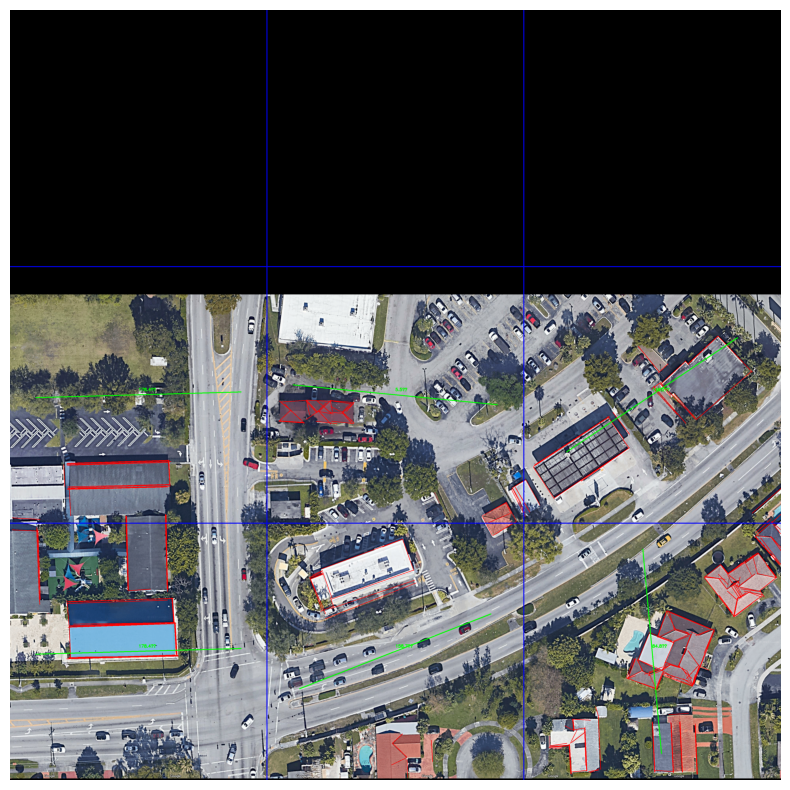

True

In [8]:
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans

# Load a pretrained YOLOv8n model
model = YOLO("C:/Users/F/OneDrive/Desktop/aligner/best.pt")

# Run inference on the image
results = model("C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_0_35840.png", save=True, show_labels=False, save_txt=True, save_conf=True, conf=0.0001)

# Load the image
image_path = "C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_0_35840.png"
image = cv2.imread(image_path)

# Prepare lines from YOLO predictions
lines = []

# Iterate over the results and extract predicted lines
for result in results:
    boxes = result.boxes  # Extract the boxes from the result
    for box in boxes:
        # Extract bounding box coordinates and class
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # Convert to integer list
        conf = box.conf[0].item()  # Extract confidence score
        cls = int(box.cls[0].item())  # Extract class index

        # Depending on the class, determine whether to draw positive or negative diagonal
        if cls == 1:  # Class 1: Draw positive diagonal
            lines.append({'points': [(x1, y1), (x2, y2)], 'confidence': conf})
        elif cls == 0:  # Class 0: Draw negative diagonal
            lines.append({'points': [(x1, y2), (x2, y1)], 'confidence': conf})

# Function to calculate line properties (angle and length)
def calculate_line_properties(points):
    x1, y1 = points[0]
    x2, y2 = points[-1]
    dx = x2 - x1
    dy = y2 - y1
    angle = math.degrees(math.atan2(dy, dx))
    if angle < 0:
        angle += 180
    length = math.sqrt(dx**2 + dy**2)
    return angle, length

# Clustering lines and visualizing the dominant orientation per grid cell
def display_lines_and_clusters(image, lines, grid_size=(3, 3), thickness=2):
    height, width = image.shape[:2]
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]

    # Initialize grid cells
    grid_cells = [[[] for _ in range(grid_size[1])] for _ in range(grid_size[0])]

    # Assign lines to grid cells
    for line in lines:
        points = line['points']
        angle, length = calculate_line_properties(points)

        # Determine which grid cell(s) the line belongs to
        start_row, start_col = int(points[0][1]) // cell_height, int(points[0][0]) // cell_width
        end_row, end_col = int(points[-1][1]) // cell_height, int(points[-1][0]) // cell_width

        min_row, max_row = min(start_row, end_row), max(start_row, end_row)
        min_col, max_col = min(start_col, end_col), max(start_col, end_col)

        # Add line to relevant grid cells
        for row in range(min_row, min(grid_size[0], max_row + 1)):
            for col in range(min_col, min(grid_size[1], max_col + 1)):
                grid_cells[row][col].append((angle, length, points))

        # Draw the original line
        cv2.polylines(image, [np.array(points, dtype=np.int32)], False, (0, 0, 255), thickness)

    # Process each grid cell
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            cell_lines = grid_cells[row][col]
            if cell_lines:
                angles, lengths, points = zip(*cell_lines)

                # Calculate cell center
                cell_center_x = (col + 0.5) * cell_width
                cell_center_y = (row + 0.5) * cell_height
                cell_center = (cell_center_x, cell_center_y)

                # Determine number of clusters
                n_clusters = min(6, len(angles))

                # Apply k-means clustering
                kmeans = KMeans(n_clusters=n_clusters)
                labels = kmeans.fit_predict(np.array(angles).reshape(-1, 1))

                # Find the dominant cluster
                cluster_weights = np.bincount(labels, weights=lengths)
                dominant_cluster = np.argmax(cluster_weights)
                dominant_angle = kmeans.cluster_centers_[dominant_cluster][0]

                # Draw the dominant orientation line for this cell
                line_length = min(cell_width, cell_height) * 0.8
                angle_rad = math.radians(dominant_angle)
                dx = math.cos(angle_rad) * line_length / 2
                dy = math.sin(angle_rad) * line_length / 2
                start_x = int(cell_center_x - dx)
                start_y = int(cell_center_y - dy)
                end_x = int(cell_center_x + dx)
                end_y = int(cell_center_y + dy)

                # Draw the dominant orientation line
                cv2.line(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 3)

                # Add text to show the dominant angle
                text_position = (int(cell_center_x), int(cell_center_y) - 20)
                cv2.putText(image, f"{dominant_angle:.1f}°", text_position, 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)

    # Draw grid lines
    for i in range(1, grid_size[0]):
        cv2.line(image, (0, i * cell_height), (width, i * cell_height), (255, 0, 0), 3)
    for j in range(1, grid_size[1]):
        cv2.line(image, (j * cell_width, 0), (j * cell_width, height), (255, 0, 0), 3)

    return image

# Apply the clustering and display the results
image_with_lines_and_clusters = display_lines_and_clusters(image.copy(), lines, grid_size=(3, 3), thickness=2)

# Display the final image with clusters and dominant orientations
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(image_with_lines_and_clusters, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save the resulting image
output_path = "C:/Users/F/OneDrive/Desktop/aligner/result_image_with_clusters.png"
cv2.imwrite(output_path, image_with_lines_and_clusters)


In [2]:
import pickle

# نام فایل پیکل را مشخص کنید
file_name = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_0_35840.pkl'

# باز کردن و خواندن محتوای فایل پیکل
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# چاپ کردن محتوای فایل پیکل
print(data)


[{'label': 'seg', 'points': [[5.0, 2316.0], [5.0, 2330.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[5.0, 2330.0], [8.0, 2430.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[8.0, 2430.0], [11.0, 2496.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[11.0, 2496.0], [12.0, 2605.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[12.0, 2605.0], [11.0, 2648.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[14.0, 2652.0], [27.0, 3067.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[11.0, 2648.0], [132.0, 2652.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[132.0, 2652.0], [14.0, 2652.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[12.0, 2605.0], [136.0, 2604.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[136.0, 2604.0], [136.0, 2612.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[132.0, 2652.0], [136.0, 2612.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[142.0, 2653.0], [132.0, 2652.0]], 'shape_typ

In [3]:
import pickle
import cv2
import numpy as np
import math
from ultralytics import YOLO
from sklearn.cluster import KMeans

# Load YOLO model
model = YOLO("C:/Users/F/OneDrive/Desktop/aligner/best.pt")

# Run inference on the image
image_path = "C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_0_35840.png"
results = model(image_path, save=True, show_labels=False, save_txt=True, save_conf=True, conf=0.0001)

# Load the pickle file
pickle_file = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_0_35840.pkl'

with open(pickle_file, 'rb') as file:
    data = pickle.load(file)

# Prepare lines from YOLO predictions
lines = []

for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls = int(box.cls[0].item())
        if cls == 1:
            lines.append({'points': [(x1, y1), (x2, y2)]})
        elif cls == 0:
            lines.append({'points': [(x1, y2), (x2, y1)]})

# Function to calculate line properties (angle and length)
def calculate_line_properties(points):
    x1, y1 = points[0]
    x2, y2 = points[-1]
    dx = x2 - x1
    dy = y2 - y1
    angle = math.degrees(math.atan2(dy, dx))
    if angle < 0:
        angle += 180
    return angle

# Function to perform clustering and get final orientation per grid
def get_grid_orientations(lines, image_shape, grid_size=(3, 3)):
    height, width = image_shape[:2]
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]

    # Initialize grid cells
    grid_orientations = []
    
    # Process each grid cell
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            angles = []
            
            # Select lines that belong to the current grid cell
            for line in lines:
                points = line['points']
                start_row, start_col = int(points[0][1]) // cell_height, int(points[0][0]) // cell_width
                end_row, end_col = int(points[-1][1]) // cell_height, int(points[-1][0]) // cell_width
                if row == start_row and col == start_col:
                    angle = calculate_line_properties(points)
                    angles.append(angle)

            # If there are angles, calculate the dominant orientation using KMeans
            if angles:
                n_clusters = min(8, len(angles))
                kmeans = KMeans(n_clusters=n_clusters)
                labels = kmeans.fit_predict(np.array(angles).reshape(-1, 1))
                cluster_weights = np.bincount(labels)
                dominant_cluster = np.argmax(cluster_weights)
                dominant_angle = kmeans.cluster_centers_[dominant_cluster][0]
            else:
                dominant_angle = None  # No lines in this grid cell
            
            grid_orientations.append(dominant_angle)
    
    return grid_orientations

# Get the final orientations for the 3x3 grid
image = cv2.imread(image_path)
grid_size = (5, 5)
final_orientations = get_grid_orientations(lines, image.shape, grid_size)

# Add new dictionary with grid and orientation to the existing pickle data
new_data = {
    'aligner': {
        'grid': list(grid_size),
        'orientation': final_orientations
    }
}

data.append(new_data)  # Append the new dictionary to the existing data

# Save the updated data back to the pickle file
with open(pickle_file, 'wb') as file:
    pickle.dump(data, file)

print(f"Updated data saved to {pickle_file}")



image 1/1 C:\Users\F\OneDrive\Desktop\dataloader\Physical_Cells2\train\images\physical_cell_0_35840.png: 1024x1024 136 class_0s, 164 class_1s, 1513.7ms
Speed: 21.9ms preprocess, 1513.7ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\detect\predict27
1 label saved to runs\detect\predict27\labels
Updated data saved to C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_0_35840.pkl


add information to pickle file 

In [8]:
import os
import pickle
import numpy as np
import cv2
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

# Increase maximum image size
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        image = np.array(img)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def load_pickle(pickle_path: str):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    return data

def calculate_line_properties(points):
    x1, y1 = points[0]
    x2, y2 = points[-1]
    dx = x2 - x1
    dy = y2 - y1
    angle = math.degrees(math.atan2(dy, dx))
    if angle < 0:
        angle += 180
    length = math.sqrt(dx**2 + dy**2)
    return angle, length

def weighted_kmeans(angles, weights, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(np.array(angles).reshape(-1, 1), sample_weight=weights)
    return kmeans.labels_, kmeans.cluster_centers_

def calculate_grid_distance(i1, j1, i2, j2):
    return abs(i2 - i1) + abs(j2 - j1)

def get_grid_orientations(data: list, image_shape, grid_size=(5, 5)):
    height, width = image_shape[:2]
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]

    # Initialize grid cells
    grid_cells = [[[] for _ in range(grid_size[1])] for _ in range(grid_size[0])]

    # Assign lines to grid cells
    for entry in data:
        if isinstance(entry, dict) and 'points' in entry:
            points = entry['points']
            angle, length = calculate_line_properties(points)
            
            # Determine which grid cell(s) the line belongs to
            start_row, start_col = int(points[0][1]) // cell_height, int(points[0][0]) // cell_width
            end_row, end_col = int(points[-1][1]) // cell_height, int(points[-1][0]) // cell_width
            
            # Add line to all relevant grid cells, including overlapping areas
            min_row, max_row = min(start_row, end_row), max(start_row, end_row)
            min_col, max_col = min(start_col, end_col), max(start_col, end_col)
            
            for row in range(min_row, min(grid_size[0], max_row + 1)):
                for col in range(min_col, min(grid_size[1], max_col + 1)):
                    grid_cells[row][col].append((angle, length, points))

    # Process each grid cell
    grid_orientations = []
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            all_angles = []
            all_weights = []
            
            # Consider lines from all grid cells
            for i2 in range(grid_size[0]):
                for j2 in range(grid_size[1]):
                    cell_lines = grid_cells[i2][j2]
                    for angle, length, _ in cell_lines:
                        d = calculate_grid_distance(i, j, i2, j2)
                        weight = length / (((d * 3) + 1) ** 2)
                        all_angles.append(angle)
                        all_weights.append(weight)
            
            if all_angles:
                # Determine number of clusters
                n_clusters = min(6, len(all_angles))
                
                # Apply weighted k-means clustering
                labels, centers = weighted_kmeans(all_angles, all_weights, n_clusters)
                
                # Find the cluster with the highest total weight
                cluster_weights = [sum(all_weights[k] for k in range(len(labels)) if labels[k] == c) for c in range(len(centers))]
                dominant_cluster = np.argmax(cluster_weights)
                dominant_angle = centers[dominant_cluster][0]
                
                grid_orientations.append(dominant_angle)
            else:
                grid_orientations.append(None)  # No lines in this grid cell

    return grid_orientations

def main():
    # Define paths
    image_path = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_0_36864.png'
    pickle_path = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_0_36864.pkl'

    # Load image and pickle file
    image = load_image(image_path)
    data = load_pickle(pickle_path)

    # Get grid orientations
    grid_size = (5, 5)
    final_orientations = get_grid_orientations(data, image.shape, grid_size)

    # Prepare new aligner data
    new_aligner_data = {
        'grid': list(grid_size),
        'orientation': final_orientations
    }

    # Check if 'aligner' key exists and update or add accordingly
    aligner_found = False
    for item in data:
        if isinstance(item, dict) and 'aligner' in item:
            item['aligner'] = new_aligner_data
            aligner_found = True
            print("Existing 'aligner' data updated.")
            break
    
    if not aligner_found:
        data.append({'aligner': new_aligner_data})
        print("New 'aligner' data added.")

    # Save the updated data back to the pickle file
    with open(pickle_path, 'wb') as file:
        pickle.dump(data, file)

    print(f"Updated data saved to {pickle_path}")

if __name__ == "__main__":
    main()

New 'aligner' data added.
Updated data saved to C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_0_36864.pkl


In [1]:
import os
import pickle
import numpy as np
import cv2
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

# Increase maximum image size
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        image = np.array(img)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def load_pickle(pickle_path: str):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    return data

def calculate_line_properties(points):
    x1, y1 = points[0]
    x2, y2 = points[-1]
    dx = x2 - x1
    dy = y2 - y1
    angle = math.degrees(math.atan2(dy, dx))
    if angle < 0:
        angle += 180
    length = math.sqrt(dx**2 + dy**2)
    return angle, length

def weighted_kmeans(angles, weights, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(np.array(angles).reshape(-1, 1), sample_weight=weights)
    return kmeans.labels_, kmeans.cluster_centers_

def calculate_grid_distance(i1, j1, i2, j2):
    return abs(i2 - i1) + abs(j2 - j1)

def get_grid_orientations(data: list, image_shape, grid_size=(5, 5)):
    height, width = image_shape[:2]
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]

    # Initialize grid cells
    grid_cells = [[[] for _ in range(grid_size[1])] for _ in range(grid_size[0])]

    # Assign lines to grid cells
    for entry in data:
        if isinstance(entry, dict) and 'points' in entry:
            points = entry['points']
            angle, length = calculate_line_properties(points)
            
            # Determine which grid cell(s) the line belongs to
            start_row, start_col = int(points[0][1]) // cell_height, int(points[0][0]) // cell_width
            end_row, end_col = int(points[-1][1]) // cell_height, int(points[-1][0]) // cell_width
            
            # Add line to all relevant grid cells, including overlapping areas
            min_row, max_row = min(start_row, end_row), max(start_row, end_row)
            min_col, max_col = min(start_col, end_col), max(start_col, end_col)
            
            for row in range(min_row, min(grid_size[0], max_row + 1)):
                for col in range(min_col, min(grid_size[1], max_col + 1)):
                    grid_cells[row][col].append((angle, length, points))

    # Process each grid cell
    grid_orientations = []
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            all_angles = []
            all_weights = []
            
            # Consider lines from all grid cells
            for i2 in range(grid_size[0]):
                for j2 in range(grid_size[1]):
                    cell_lines = grid_cells[i2][j2]
                    for angle, length, _ in cell_lines:
                        d = calculate_grid_distance(i, j, i2, j2)
                        weight = length / (((d * 3) + 1) ** 2)
                        all_angles.append(angle)
                        all_weights.append(weight)
            
            if all_angles:
                # Determine number of clusters
                n_clusters = min(6, len(all_angles))
                
                # Apply weighted k-means clustering
                labels, centers = weighted_kmeans(all_angles, all_weights, n_clusters)
                
                # Find the cluster with the highest total weight
                cluster_weights = [sum(all_weights[k] for k in range(len(labels)) if labels[k] == c) for c in range(len(centers))]                
                dominant_cluster = np.argmax(cluster_weights)
                dominant_angle = centers[dominant_cluster][0]
                
                grid_orientations.append(dominant_angle)
            else:
                grid_orientations.append(None)  # No lines in this grid cell

    return grid_orientations

def process_physical_cells(image_folder: str, pickle_folder: str):
    # Get all .png files in the image folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

    for image_file in image_files:
        # Extract base name (without extension) to find the corresponding .pkl file
        base_name = os.path.splitext(image_file)[0]
        image_path = os.path.join(image_folder, image_file)
        pickle_path = os.path.join(pickle_folder, base_name + '.pkl')

        if not os.path.exists(pickle_path):
            print(f"Pickle file {pickle_path} not found. Skipping {image_file}.")
            continue

        # Load image and pickle file
        image = load_image(image_path)
        data = load_pickle(pickle_path)

        # Get grid orientations
        grid_size = (5, 5)
        final_orientations = get_grid_orientations(data, image.shape, grid_size)

        # Prepare new aligner data
        new_aligner_data = {
            'grid': list(grid_size),
            'orientation': final_orientations
        }

        # Check if 'aligner' key exists and update or add accordingly
        aligner_found = False
        for item in data:
            if isinstance(item, dict) and 'aligner' in item:
                item['aligner'] = new_aligner_data
                aligner_found = True
                print(f"Existing 'aligner' data updated for {pickle_path}.")
                break
        
        if not aligner_found:
            data.append({'aligner': new_aligner_data})
            print(f"New 'aligner' data added for {pickle_path}.")

        # Save the updated data back to the pickle file
        with open(pickle_path, 'wb') as file:
            pickle.dump(data, file)

        print(f"Updated data saved to {pickle_path}.")

if __name__ == "__main__":
    # Define the paths to the image and pickle folders
    image_folder = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images'
    pickle_folder = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels'
    
    # Process all physical cells
    process_physical_cells(image_folder, pickle_folder)


New 'aligner' data added for C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels\physical_cell_0_11264.pkl.
Updated data saved to C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels\physical_cell_0_11264.pkl.
New 'aligner' data added for C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels\physical_cell_0_12288.pkl.
Updated data saved to C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels\physical_cell_0_12288.pkl.
New 'aligner' data added for C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels\physical_cell_0_14336.pkl.
Updated data saved to C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels\physical_cell_0_14336.pkl.
New 'aligner' data added for C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels\physical_cell_0_15360.pkl.
Updated data saved to C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels\physical_cell_0_15360.pkl.
New 'aligner' data added for C:/User

KeyboardInterrupt: 

In [2]:
import pickle

# نام فایل پیکل را مشخص کنید
file_name = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_0_21504.pkl'

# باز کردن و خواندن محتوای فایل پیکل
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# چاپ کردن محتوای فایل پیکل
print(data)


[{'label': 'seg', 'points': [[12.0, 1456.0], [11.0, 1411.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[12.0, 1456.0], [17.0, 1499.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[24.0, 2660.0], [23.0, 2713.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[26.0, 3784.0], [25.0, 3735.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[23.0, 2713.0], [27.0, 2872.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[0.0, 1691.0], [29.0, 1691.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[29.0, 3026.0], [27.0, 3089.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[27.0, 3089.0], [32.0, 3158.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[29.0, 1691.0], [33.0, 1845.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[36.0, 2339.0], [44.0, 2528.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[85.0, 1999.0], [85.0, 2051.0]], 'shape_type': 'line'}, {'label': 'seg', 'points': [[88.0, 3013.0], [88.0, 3024.0]], 'shape_type': '

Grid: [5, 5], Orientation: [88.42729808636706, 88.51082424170107, 88.48932857880976, 88.45443611222095, 88.31416391912889, 88.55812655144912, 88.35762356861594, 88.27017807935502, 88.32185608778337, 88.31574845041504, 88.51012601942676, 88.24256192849124, 88.23844395590787, 88.31158101981337, 88.39470459131516, 88.70344316137925, 88.85415314407292, 89.5276791811501, 88.72848118317081, 88.42517280208374, 178.58940272019854, 178.5647249268457, 156.07615939383015, 88.46330988961125, 88.71034880558588]


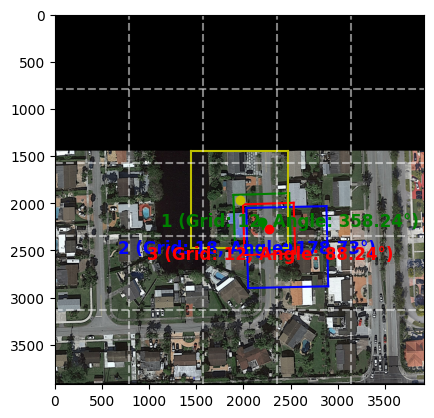

C:\Users\F\AppData\Local\Temp\ipykernel_8772\3967723143.py:94: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


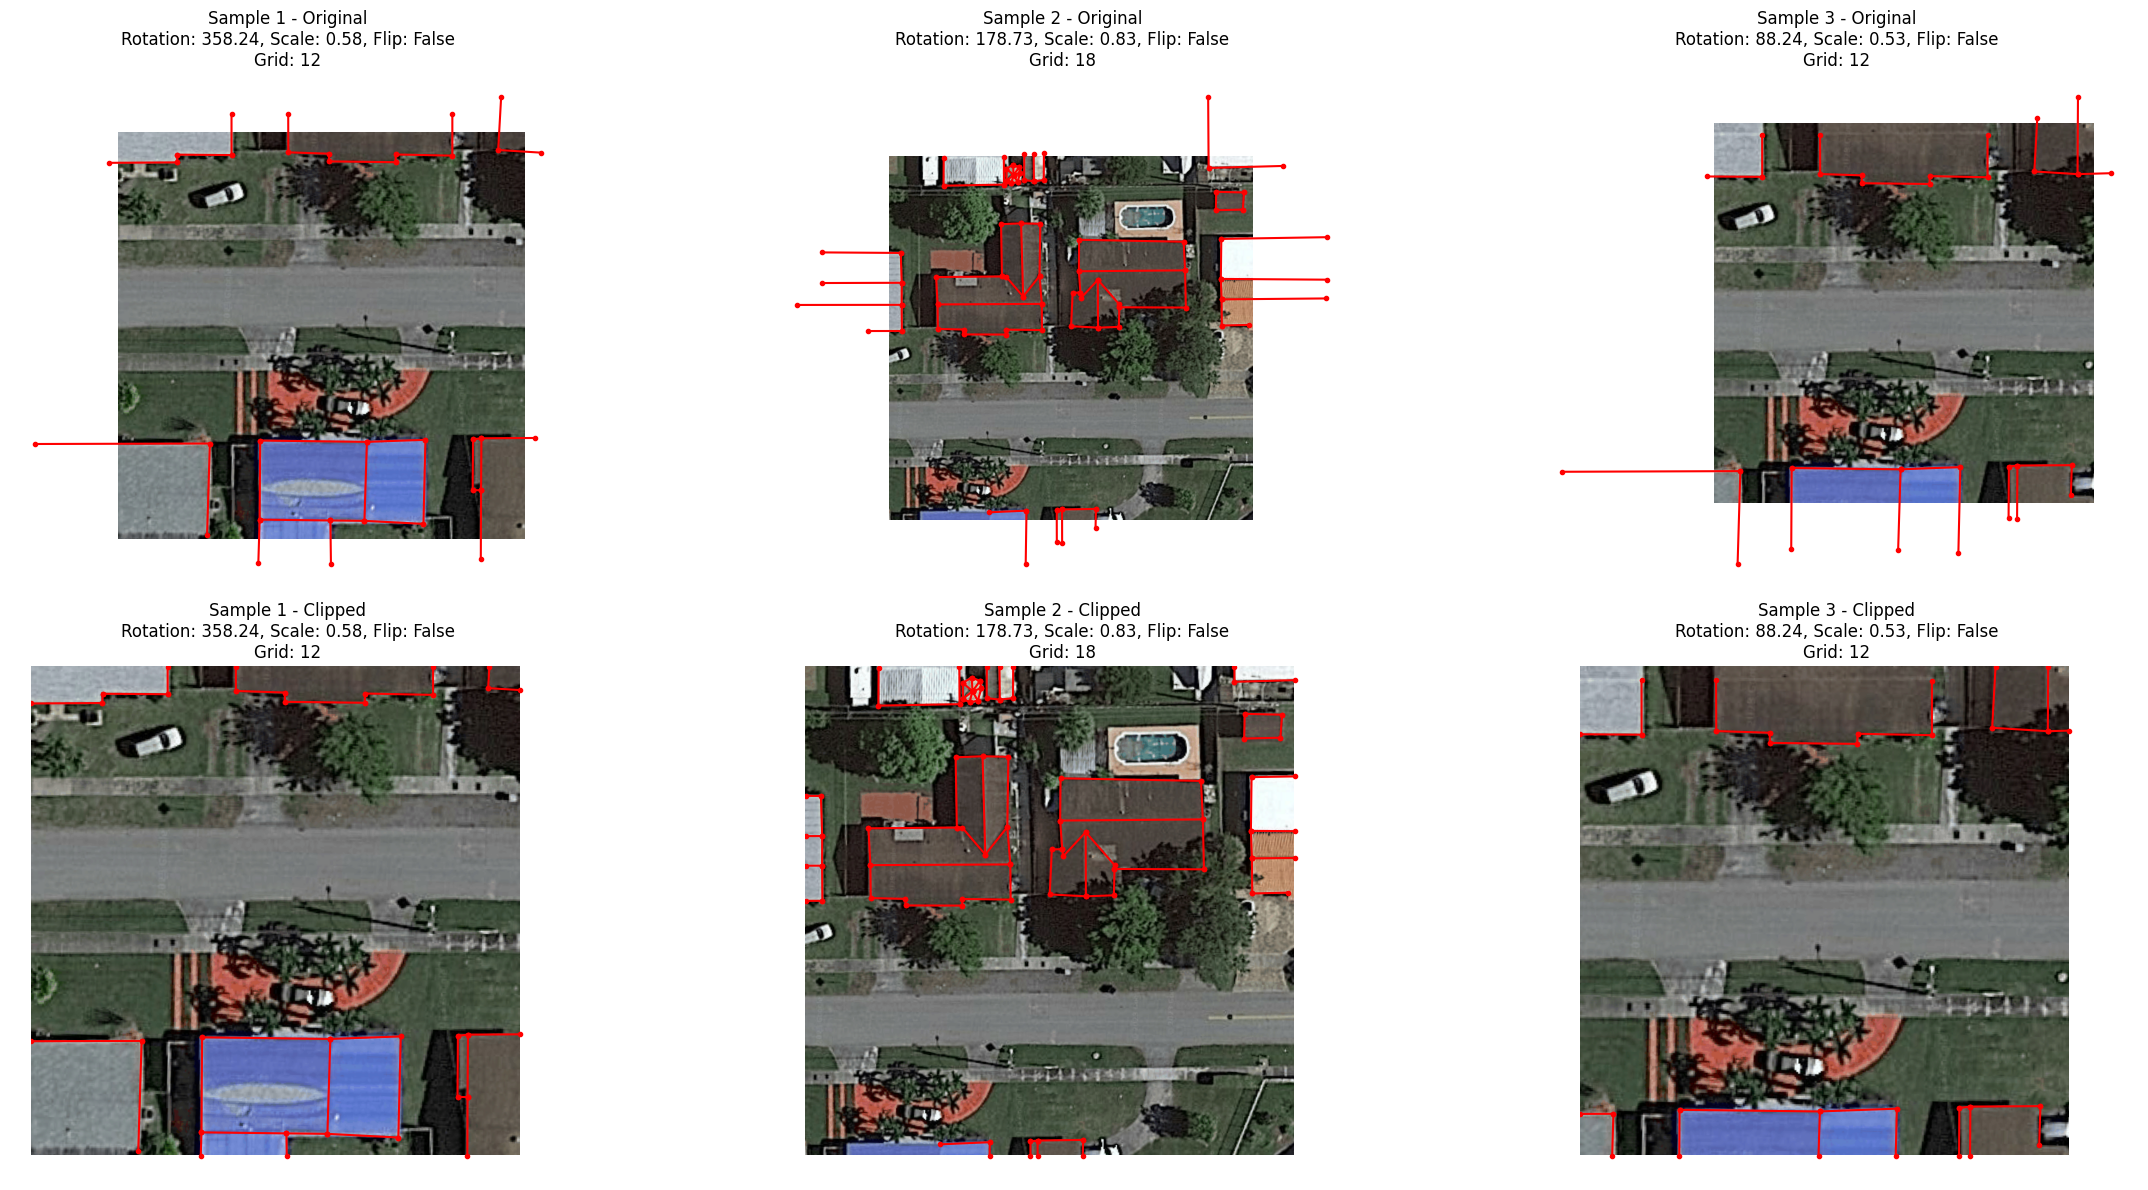

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from shapely.geometry import Point, box, Polygon, LineString
from shapely.affinity import rotate, scale
import random
import pickle
from PIL import Image

def get_bounding_polygon(center: Point, width: int, height: int) -> box:
    return box(
        center.x - width / 2,
        center.y - height / 2,
        center.x + width / 2,
        center.y + height / 2,
    )

def draw_rotated_box(ax, box_points: np.ndarray, color='g', label=None):
    for i in range(4):
        pt1 = (box_points[i][0], box_points[i][1])
        pt2 = (box_points[(i + 1) % 4][0], box_points[(i + 1) % 4][1])
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color + '-')
        
    if label is not None:
        mid_point = (box_points[0][0] + box_points[1][0]) / 2, (box_points[0][1] + box_points[1][1]) / 2
        ax.text(mid_point[0], mid_point[1], label, color=color, fontsize=12, fontweight='bold', ha='center', va='center')

def determine_grid_and_orientation(point: Point, cell_width: int, cell_height: int, grid_size: list, orientations: list):
    grid_width = cell_width // grid_size[0]
    grid_height = cell_height // grid_size[1]
    
    grid_x = int(point.x // grid_width)
    grid_y = int(point.y // grid_height)
    
    grid_index = grid_y * grid_size[0] + grid_x
    base_orientation = orientations[grid_index] if orientations[grid_index] is not None else random.uniform(0, 360)
    
    # Randomly choose between +90, -90, +180, or -270 (which is equivalent to +90)
    rotation_choice = random.choice([0, 90, 180, 270])
    
    final_orientation = (base_orientation + rotation_choice) % 360
    
    return grid_index, final_orientation

def sample_random_points_and_draw_boxes(image: np.ndarray, cell_center: Point, cell_size: int, sample_size: int, grid_size: list, orientations: list):
    colors = ['g', 'b', 'r']
    samples = []
    
    cell_height, cell_width = image.shape[:2]
    
    for i in range(3):
        r = random.random()
        sample_center = Point(cell_center.x + r * 512, cell_center.y + r * 512)
        
        grid_index, rotation_angle = determine_grid_and_orientation(sample_center, cell_width, cell_height, grid_size, orientations)
        
        scale_val = random.uniform(0.5, 2)
        flipy = random.choice([True, False])
        
        bounding_box = get_bounding_polygon(sample_center, sample_size, sample_size)
        bounding_box = scale(bounding_box, xfact=scale_val, yfact=scale_val, origin=sample_center)
        bounding_box = rotate(bounding_box, rotation_angle, origin=sample_center)
        
        samples.append((bounding_box, sample_center, rotation_angle, scale_val, flipy, colors[i], str(i+1), grid_index))
    
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    for bounding_box, sample_center, rotation_angle, scale_val, flipy, color, label, grid_index in samples:
        draw_rotated_box(ax, np.array(bounding_box.exterior.coords), color=color, label=f"{label} (Grid: {grid_index}, Angle: {rotation_angle:.2f}°)")
        ax.plot(sample_center.x, sample_center.y, 'o', color=color)
    
    center_bounding_box = get_bounding_polygon(cell_center, sample_size, sample_size)
    draw_rotated_box(ax, np.array(center_bounding_box.exterior.coords), color='y')
    ax.plot(cell_center.x, cell_center.y, 'yo')

    # Draw grid lines
    for i in range(1, grid_size[0]):
        ax.axvline(x=i * cell_width // grid_size[0], color='w', linestyle='--', alpha=0.5)
    for i in range(1, grid_size[1]):
        ax.axhline(y=i * cell_height // grid_size[1], color='w', linestyle='--', alpha=0.5)

    plt.show()
    
    return samples

def rect_scale_pad(rect, scale=1.0, pad=0):
    center, size, angle = rect
    new_size = (size[0] * scale + pad, size[1] * scale + pad)
    return (center, new_size, angle)

def img_rectangle_cut(img, rect, target_size=(1024, 1024), flipy=False):
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    width, height = target_size

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))
    
    if flipy:
        warped = cv2.flip(warped, 1)
    
    return warped, rect, M

def load_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        image = np.array(img)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def load_pickle(pickle_path: str):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    
    # Extract aligner data if present
    aligner_data = None
    for item in data:
        if isinstance(item, dict) and 'aligner' in item:
            aligner_data = item['aligner']
            break
    
    return data, aligner_data

def find_intersection_with_border(point1, point2, img_width, img_height):
    border_lines = [
        LineString([(0, 0), (img_width, 0)]),  # Top border
        LineString([(0, 0), (0, img_height)]),  # Left border
        LineString([(img_width, 0), (img_width, img_height)]),  # Right border
        LineString([(0, img_height), (img_width, img_height)])  # Bottom border
    ]
    
    line = LineString([point1, point2])
    for border in border_lines:
        if line.intersects(border):
            intersection = line.intersection(border)
            if intersection.geom_type == 'Point':
                return (intersection.x, intersection.y)
    return None

def transform_keypoints(keypoints, M, flipy, width):
    if keypoints.size == 0:
        return np.array([])
    
    if len(keypoints.shape) == 1:
        keypoints = keypoints.reshape(-1, 2)
    
    keypoints_homogeneous = np.hstack([keypoints, np.ones((keypoints.shape[0], 1))])
    transformed_keypoints_homogeneous = np.dot(keypoints_homogeneous, M.T)
    transformed_keypoints = transformed_keypoints_homogeneous[:, :2] / transformed_keypoints_homogeneous[:, 2][:, np.newaxis]
    
    if flipy:
        transformed_keypoints[:, 0] = width - transformed_keypoints[:, 0]
        
    return transformed_keypoints

def draw_lines_between_keypoints(ax, keypoints, color='r'):
    for i in range(0, len(keypoints) - 1, 2):
        pt1 = keypoints[i]
        pt2 = keypoints[i + 1]
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color + '-')

def clip_keypoints_to_image(keypoints, img_width, img_height):
    clipped_keypoints = keypoints.copy()
    for i in range(0, len(keypoints) - 1, 2):
        pt1 = keypoints[i]
        pt2 = keypoints[i + 1]
        if not (0 <= pt1[0] <= img_width and 0 <= pt1[1] <= img_height):
            intersection = find_intersection_with_border(pt1, pt2, img_width, img_height)
            if intersection:
                clipped_keypoints[i] = intersection
        if not (0 <= pt2[0] <= img_width and 0 <= pt2[1] <= img_height):
            intersection = find_intersection_with_border(pt2, pt1, img_width, img_height)
            if intersection:
                clipped_keypoints[i + 1] = intersection
    return clipped_keypoints
def find_intersecting_keypoints(bbox, lines):
    bbox_polygon = Polygon(bbox)
    keypoints = []

    for line in lines:
        if 'points' not in line:
            # Skip if the entry doesn't have 'points'
            continue
        line_string = LineString(line['points'])
        if bbox_polygon.intersects(line_string):
            for point in line['points']:
                keypoints.append(point)

    return np.array(keypoints)

def main():
    cell_image_path = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/images/physical_cell_0_21504.png'
    pickle_path = 'C:/Users/F/OneDrive/Desktop/dataloader/Physical_Cells2/train/labels/physical_cell_0_21504.pkl'
    
    # Load image and data
    cell_image = load_image(cell_image_path)
    cell_data, aligner_data = load_pickle(pickle_path)
    
    # Image properties
    cell_height, cell_width = cell_image.shape[:2]
    cell_center = Point(cell_width // 2, cell_height // 2)
    
    # Check aligner data
    if aligner_data:
        grid = aligner_data['grid']
        orientation = aligner_data['orientation']
        print(f"Grid: {grid}, Orientation: {orientation}")
    else:
        print("No aligner data found. Using default values.")
        grid = [5, 5]
        orientation = [random.uniform(0, 360) for _ in range(9)]
    
    # Sample and draw boxes
    samples = sample_random_points_and_draw_boxes(cell_image, cell_center, cell_width, 1024, grid, orientation)
    
    fig, axs = plt.subplots(2, 3, figsize=(24, 12))

    for i, (bounding_box, sample_center, rotation_angle, scale_val, flipy, color, label, grid_index) in enumerate(samples):
        box_coords = np.array(bounding_box.exterior.coords[:-1], dtype="float32")
        rect = cv2.minAreaRect(box_coords)
        
        rect_scaled = rect_scale_pad(rect, scale=1.0, pad=40)
        target_size = (1024, 1024)
        cropped_image, rect_target, M = img_rectangle_cut(cell_image, rect_scaled, target_size=target_size, flipy=flipy)
        
        keypoints = find_intersecting_keypoints(box_coords, cell_data)
        transformed_keypoints = transform_keypoints(keypoints, M, flipy=flipy, width=target_size[0])
        
        clipped_keypoints = clip_keypoints_to_image(transformed_keypoints, target_size[0], target_size[1])
        
        # Plot original keypoints and lines
        axs[0, i].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        axs[0, i].plot(transformed_keypoints[:, 0], transformed_keypoints[:, 1], 'r.')
        draw_lines_between_keypoints(axs[0, i], transformed_keypoints, color='r')
        axs[0, i].set_title(f'Sample {i+1} - Original\nRotation: {rotation_angle:.2f}, Scale: {scale_val:.2f}, Flip: {flipy}\nGrid: {grid_index}')
        axs[0, i].axis('off')
        
        # Plot clipped keypoints and lines
        axs[1, i].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        axs[1, i].plot(clipped_keypoints[:, 0], clipped_keypoints[:, 1], 'r.')
        draw_lines_between_keypoints(axs[1, i], clipped_keypoints, color='r')
        axs[1, i].set_title(f'Sample {i+1} - Clipped\nRotation: {rotation_angle:.2f}, Scale: {scale_val:.2f}, Flip: {flipy}\nGrid: {grid_index}')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()